In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load cleaned data
df = pd.read_csv(r'C:\Users\bheemanathi\Downloads\ecommerce_cleaned.csv')
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

print(f"✅ Loaded {len(df):,} rows")
print(f"📅 Date range: {df['Transaction_Date'].min().date()} → {df['Transaction_Date'].max().date()}")

✅ Loaded 100,000 rows
📅 Date range: 2023-12-07 → 2024-12-06


## Calculate RFM


In [2]:
# Reference date = day after last transaction
reference_date = pd.to_datetime('2024-12-07')

rfm = df.groupby('Customer_ID').agg(
    Last_Purchase = ('Transaction_Date', 'max'),
    Frequency     = ('Transaction_ID', 'count'),
    Monetary      = ('Revenue', 'sum')
).reset_index()

# Recency = how many days since last purchase
rfm['Recency'] = (reference_date - rfm['Last_Purchase']).dt.days

# Clean up
rfm = rfm[['Customer_ID', 'Recency', 'Frequency', 'Monetary']]
rfm['Monetary'] = rfm['Monetary'].round(2)

print(f"✅ RFM calculated for {len(rfm):,} customers")
print()
print(rfm.describe().round(2))

✅ RFM calculated for 19,865 customers

        Recency  Frequency  Monetary
count  19865.00   19865.00  19865.00
mean      71.20       5.03   2784.35
std       66.76       2.21   1543.82
min        1.00       1.00     11.14
25%       22.00       3.00   1643.07
50%       50.00       5.00   2589.29
75%      100.00       6.00   3706.17
max      366.00      18.00  12021.14


## Score Each Customer 1 to 5


In [3]:
# Score Recency — lower days = better = score 5
rfm['R_Score'] = pd.qcut(rfm['Recency'],   q=5, labels=[5,4,3,2,1])

# Score Frequency — higher = better = score 5
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])

# Score Monetary — higher = better = score 5
rfm['M_Score'] = pd.qcut(rfm['Monetary'],  q=5, labels=[1,2,3,4,5])

# Convert to int
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Combined RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("✅ RFM Scores calculated!")
print(rfm[['Customer_ID','Recency','Frequency','Monetary','R_Score','F_Score','M_Score','RFM_Score']].head(10))

✅ RFM Scores calculated!
      Customer_ID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0      Customer_1       20          5   2932.58        4        3        3   
1     Customer_10      176          3   2925.10        1        1        3   
2    Customer_100      219          5   2927.21        1        3        3   
3   Customer_1000      203          3   2208.97        1        1        3   
4  Customer_10000      207          3   2650.34        1        1        3   
5  Customer_10001      177          2   1581.16        1        1        2   
6  Customer_10002      137          5   1552.39        1        3        2   
7  Customer_10003       51          6   3098.15        3        4        4   
8  Customer_10004       36          5   1532.68        4        3        2   
9  Customer_10005        1          3   1443.74        5        1        2   

  RFM_Score  
0       433  
1       113  
2       133  
3       113  
4       113  
5       112  
6       132  
7   

## Assign Customer Segments


In [9]:
def assign_segment(row):
    r = row['R_Score']
    f = row['F_Score']
    m = row['M_Score']
    
    # ✅ Cannot Lose FIRST — before At Risk
    if r <= 2 and f >= 4 and m >= 4:
        return 'Cannot Lose'
    elif r >= 4 and f >= 4 and m >= 4:
        return 'Champion'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal'
    elif r >= 3 and f <= 2:
        return 'Potential Loyal'
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r == 1 and f <= 2:
        return 'Lost'
    else:
        return 'Needs Attention'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)
print("✅ Fixed Segments:")
print(rfm['Segment'].value_counts())

✅ Fixed Segments:
Segment
Loyal              3857
Needs Attention    3709
Potential Loyal    3523
Champion           3295
Lost               2749
Cannot Lose        1396
At Risk            1336
Name: count, dtype: int64


## Segment Summary

In [10]:
segment_summary = rfm.groupby('Segment').agg(
    Customer_Count = ('Customer_ID', 'count'),
    Avg_Recency    = ('Recency',    'mean'),
    Avg_Frequency  = ('Frequency',  'mean'),
    Avg_Monetary   = ('Monetary',   'mean'),
    Total_Revenue  = ('Monetary',   'sum')
).reset_index()

segment_summary['Avg_Recency']   = segment_summary['Avg_Recency'].round(0)
segment_summary['Avg_Frequency'] = segment_summary['Avg_Frequency'].round(1)
segment_summary['Avg_Monetary']  = segment_summary['Avg_Monetary'].round(2)
segment_summary['Total_Revenue'] = segment_summary['Total_Revenue'].round(2)
segment_summary['Revenue_%']     = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)

segment_summary = segment_summary.sort_values('Total_Revenue', ascending=False)

print("="*70)
print("📊 RFM SEGMENT SUMMARY")
print("="*70)
print(segment_summary.to_string(index=False))

📊 RFM SEGMENT SUMMARY
        Segment  Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  Total_Revenue  Revenue_%
       Champion            3295         17.0            7.7       4619.96    15222758.45       27.5
          Loyal            3857         37.0            6.1       3482.99    13433878.22       24.3
Potential Loyal            3523         31.0            3.2       1817.26     6402209.65       11.6
Needs Attention            3709         74.0            4.2       1709.25     6339613.76       11.5
    Cannot Lose            1396        105.0            7.1       4303.42     6007570.32       10.9
        At Risk            1336        115.0            5.3       2986.38     3989802.82        7.2
           Lost            2749        193.0            2.6       1424.24     3915247.85        7.1


## Visualize Segments (Chart)


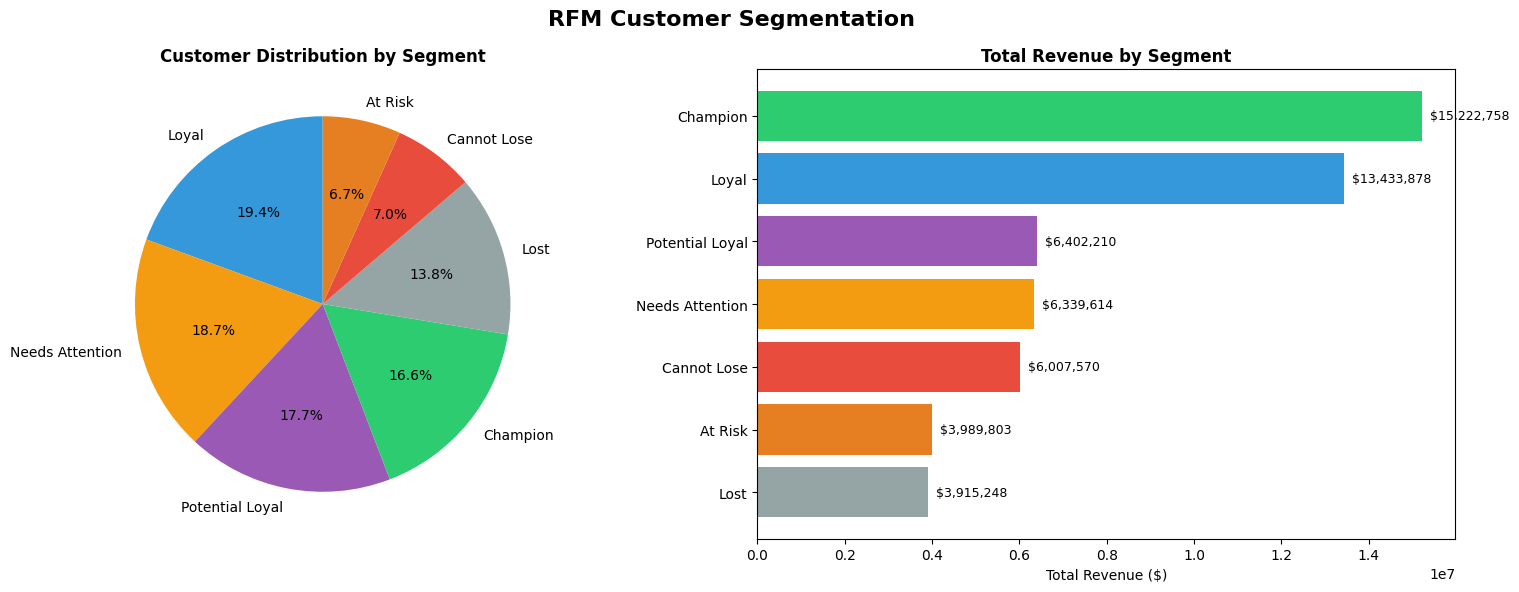

✅ Chart saved!


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('RFM Customer Segmentation', fontsize=16, fontweight='bold')

# Colors for segments
colors = {
    'Champion':        '#2ecc71',
    'Loyal':           '#3498db', 
    'Potential Loyal': '#9b59b6',
    'At Risk':         '#e67e22',
    'Cannot Lose':     '#e74c3c',
    'Lost':            '#95a5a6',
    'Needs Attention': '#f39c12'
}

seg_counts = rfm['Segment'].value_counts()
seg_colors = [colors.get(s, '#bdc3c7') for s in seg_counts.index]

# Chart 1 — Customer Count pie
axes[0].pie(seg_counts.values, labels=seg_counts.index, 
            colors=seg_colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Customer Distribution by Segment', fontweight='bold')

# Chart 2 — Revenue by Segment bar
rev_data = segment_summary.sort_values('Total_Revenue', ascending=True)
bar_colors = [colors.get(s, '#bdc3c7') for s in rev_data['Segment']]
axes[1].barh(rev_data['Segment'], rev_data['Total_Revenue'], color=bar_colors)
axes[1].set_title('Total Revenue by Segment', fontweight='bold')
axes[1].set_xlabel('Total Revenue ($)')
for i, (val, label) in enumerate(zip(rev_data['Total_Revenue'], rev_data['Segment'])):
    axes[1].text(val, i, f'  ${val:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(r'C:\Users\bheemanathi\Downloads\rfm_segments_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved!")

 ## Business Recommendations per Segment

In [14]:
recommendations = {
    'Champion':        'Reward them! VIP program, early access, loyalty points',
    'Loyal':           'Upsell premium products, send thank you offers',
    'Potential Loyal': 'Engage with personalized emails, offer small discount',
    'At Risk':         '⚠Win back campaign — send special discount urgently',
    'Cannot Lose':     'High value but inactive — call them, big offer now',
    'Lost':            'Low priority — cheap re-engagement email only',
    'Needs Attention': 'Moderate campaign — remind them of new products'
}

print("="*65)
print("💡 BUSINESS RECOMMENDATIONS BY SEGMENT")
print("="*65)
for segment, action in recommendations.items():
    count = len(rfm[rfm['Segment'] == segment])
    rev   = rfm[rfm['Segment'] == segment]['Monetary'].sum()
    print(f"\n{action}")
    print(f"   Segment : {segment}")
    print(f"   Customers: {count:,} | Revenue: ${rev:,.2f}")

💡 BUSINESS RECOMMENDATIONS BY SEGMENT

Reward them! VIP program, early access, loyalty points
   Segment : Champion
   Customers: 3,295 | Revenue: $15,222,758.45

Upsell premium products, send thank you offers
   Segment : Loyal
   Customers: 3,857 | Revenue: $13,433,878.22

Engage with personalized emails, offer small discount
   Segment : Potential Loyal
   Customers: 3,523 | Revenue: $6,402,209.65

⚠Win back campaign — send special discount urgently
   Segment : At Risk
   Customers: 1,336 | Revenue: $3,989,802.82

High value but inactive — call them, big offer now
   Segment : Cannot Lose
   Customers: 1,396 | Revenue: $6,007,570.32

Low priority — cheap re-engagement email only
   Segment : Lost
   Customers: 2,749 | Revenue: $3,915,247.85

Moderate campaign — remind them of new products
   Segment : Needs Attention
   Customers: 3,709 | Revenue: $6,339,613.76


## Save RFM Results


In [15]:
# Save full RFM table
rfm.to_csv(r'C:\Users\bheemanathi\Downloads\ecommerce_rfm.csv', index=False)

# Save segment summary to Excel
with pd.ExcelWriter(r'C:\Users\bheemanathi\Downloads\ecommerce_rfm_results.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM_Full', index=False)
    segment_summary.to_excel(writer, sheet_name='Segment_Summary', index=False)

print("✅ RFM CSV saved!   → ecommerce_rfm.csv")
print("✅ RFM Excel saved! → ecommerce_rfm_results.xlsx")
print("✅ Chart saved!     → rfm_segments_chart.png")
print()
print("🎯 RFM Analysis Complete!")
print(f"   Total Customers Segmented: {len(rfm):,}")
print(f"   Champions (best):  {len(rfm[rfm['Segment']=='Champion']):,}")
print(f"   At Risk:           {len(rfm[rfm['Segment']=='At Risk']):,}")
print(f"   Lost:              {len(rfm[rfm['Segment']=='Lost']):,}")

✅ RFM CSV saved!   → ecommerce_rfm.csv
✅ RFM Excel saved! → ecommerce_rfm_results.xlsx
✅ Chart saved!     → rfm_segments_chart.png

🎯 RFM Analysis Complete!
   Total Customers Segmented: 19,865
   Champions (best):  3,295
   At Risk:           1,336
   Lost:              2,749
